In [227]:
import MoM as mom
import FEM as fem
import Utility as util
import Visualizations as vis
import Solvers as sol
import numpy as np

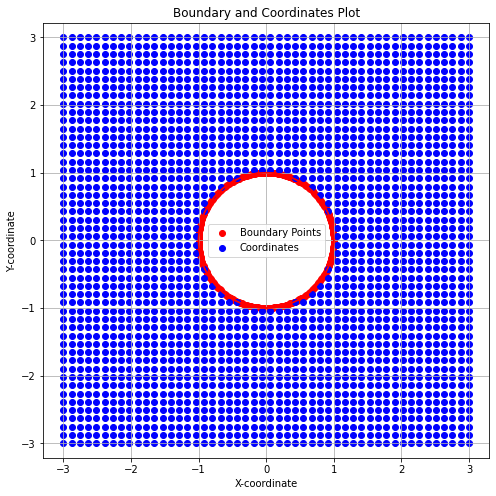

In [228]:
# Get the mesh and boundary information
radius = 1
mesh_file_name, bnd_pts, bnd_seg, col_pts = util.loadMeshInfo(256, 19)

# Generate a domain 
max_dim = (6,6)
resolution = 60
X, coordinates, X_masked, Y_masked, mask_within_radius = util.generate_meshgrid_with_plot(max_dim, resolution, radius, show_plot=False)

# Plot the generated domain and boundary.
vis.plotBoundaryAndCoordinates(bnd_pts, bnd_seg, coordinates)

In [229]:
# Determine the background material parameters
# permittivity
M_PI      = np.pi
M_2PI     = 2*M_PI
epsb = 1.0
# permeability
mub = 1.0
# wavenumber
kb = M_2PI*np.sqrt(epsb*mub)
# intrinsic admittance
etab = np.sqrt(epsb/mub)

# Determine internal material parameters
# permittivity
epsi = 2.0
# permeability
mui = mub
# wavenumber
# wavenumber
ki = M_2PI*np.sqrt(epsi*mui)
# intrinsic admittance
etai = np.sqrt(epsi/mui)


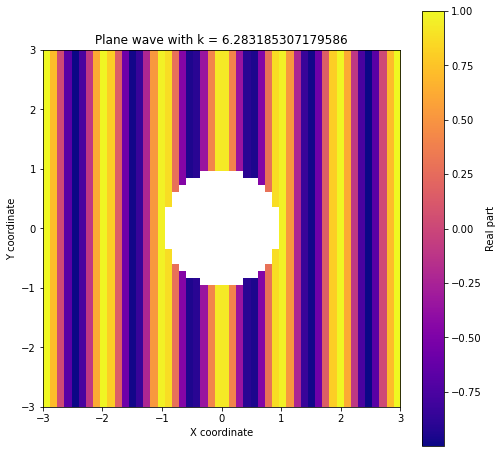

In [230]:
# plot the excitation
vis.plot_exp_kx(kb,X_masked)

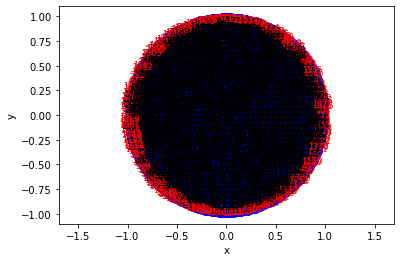

(2386,)
Time to assemble FEM matrices: 5.63 seconds
(1322, 3)
(1322, 2)


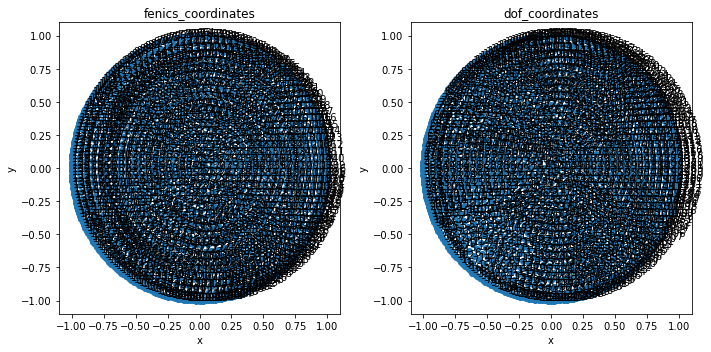

['b', 'b', 'i', 'b', 'i', 'i', 'i', 'i', 'b', 'b', 'i', 'i', 'i', 'i', 'i', 'i', 'b', 'i', 'b', 'b', 'i', 'i', 'b', 'b', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'b', 'b', 'b', 'i', 'i', 'i', 'b', 'b', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'b', 'b', 'i', 'i', 'i', 'b', 'b', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'b', 'b', 'i', 'i', 'i', 'b', 'b', 'b', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'b', 'b', 'i', 'i', 'i', 'b', 'b', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'b', 'b', 'b', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'b', 'b', 'i', 'i', 'i', 'b', 'b', 'i', 'i', 'i', 'i', 'b', 'b', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'b', 'b', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i',

In [231]:
# Get the FEM matrices
import matplotlib.pyplot as plt
K, B, T, node_labels, fenics_coordinates, dof_coordinates, boundary_dof,interior_dof = fem.dielectric_homogeneous_object(mesh_file_name, kb, epsi, mui)

# check if fenics_coordinates and coordinates are the same
print(fenics_coordinates.shape)
print(dof_coordinates.shape)

# Create 1x2 scatter plots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Scatter plot for fenics_coordinates
axs[0].scatter(fenics_coordinates[:, 0], fenics_coordinates[:, 1])
for i, coord in enumerate(fenics_coordinates):
    axs[0].annotate(str(i), (coord[0], coord[1]))
axs[0].set_title('fenics_coordinates')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')

# Scatter plot for dof_coordinates
axs[1].scatter(dof_coordinates[:, 0], dof_coordinates[:, 1])
for i, coord in enumerate(dof_coordinates):
    axs[1].annotate(str(i), (coord[0], coord[1]))
axs[1].set_title('dof_coordinates')
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')

plt.tight_layout()
plt.show()
print(node_labels)

In [232]:
# check numbers of zeroes in B
print(np.count_nonzero(B))

256


Time to assemble strong MoM matrix: 11.03 seconds


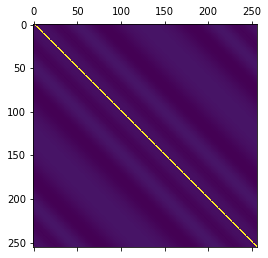

In [233]:
# Get the MoM matrices

# weak MoM matrix
Q = mom.weak_mom(bnd_pts, bnd_seg,col_pts, kb)

# strong MoM matrix
P = mom.strong_mom(bnd_pts, bnd_seg, col_pts, kb)

plt.matshow(P.real)

In [234]:
from fenics import *
def find_adjacent_boundary_cell_node_coordinates(mesh_filename):
    # Load the mesh from the given file
    mesh = Mesh(mesh_filename)
    
    # Initialize a dictionary to store the node coordinates of boundary-adjacent cells
    boundary_cell_node_coordinates = {}
    
    # Create a mesh function to mark the boundary facets
    boundary_facets = MeshFunction('size_t', mesh, mesh.topology().dim() - 1)
    boundary_facets.set_all(0)
    
    class Boundary(SubDomain):
        def inside(self, x, on_boundary):
            return on_boundary
    
    # Mark the boundary facets
    Boundary().mark(boundary_facets, 1)
    
    # Iterate over all cells in the mesh
    for cell in cells(mesh):
        # Check if any facet of the cell is on the boundary
        for facet in facets(cell):
            if boundary_facets[facet.index()] == 1:
                # Store the node coordinates for this boundary-adjacent cell
                # Only take the x and y coordinates
                node_coords = [vertex.point().array()[:2] for vertex in vertices(cell)]
                boundary_cell_node_coordinates[cell.index()] = node_coords
                break  # Once a boundary facet is found, no need to check other facets of this cell

    # Print the coordinates for each boundary-adjacent cell
    for cell_index, vertices_coords in boundary_cell_node_coordinates.items():
        print(f"Cell {cell_index} vertices coordinates:")
        for vertex_coord in vertices_coords:
            print(vertex_coord)
        print()

    return boundary_cell_node_coordinates

# Example usage
boundary_cell_node_coords = find_adjacent_boundary_cell_node_coordinates(mesh_file_name)
print(boundary_cell_node_coords)




Cell 0 vertices coordinates:
[-0.38268343 -0.92387953]
[-0.35989504 -0.9329928 ]
[-0.34727976 -0.88142141]

Cell 1 vertices coordinates:
[ 0.91420976 -0.40524131]
[ 0.92387953 -0.38268343]
[ 0.87650892 -0.35949832]

Cell 2 vertices coordinates:
[ 0.92387953 -0.38268343]
[ 0.9329928  -0.35989504]
[ 0.87650892 -0.35949832]

Cell 4 vertices coordinates:
[0.92387953 0.38268343]
[0.91420976 0.40524131]
[0.87650892 0.35949832]

Cell 7 vertices coordinates:
[-0.02454123 -0.99969882]
[-1.8369702e-16 -1.0000000e+00]
[ 0.0131688  -0.94727689]

Cell 10 vertices coordinates:
[ 0.38268343 -0.92387953]
[ 0.40524131 -0.91420976]
[ 0.37164742 -0.87142706]

Cell 12 vertices coordinates:
[ 0.21910124 -0.97570213]
[ 0.24298018 -0.97003125]
[ 0.22179898 -0.92103862]

Cell 13 vertices coordinates:
[-1.8369702e-16 -1.0000000e+00]
[ 0.02454123 -0.99969882]
[ 0.0131688  -0.94727689]

Cell 56 vertices coordinates:
[-0.07356456  0.99729046]
[-0.09801714  0.99518473]
[-0.0920392  0.9428869]

Cell 63 vertices coo

In [235]:
import numpy as np

def filter_nodes_on_circular_arc(boundary_cell_node_coords, radius, center=(0,0), tolerance=1E-6):
    """
    Filters nodes that lie on the circular arc of a given radius.
    
    :param boundary_cell_node_coords: Dictionary of cell indices to node coordinates.
    :param radius: Radius of the circular arc.
    :param center: Tuple representing the (x, y) coordinates of the circle's center.
    :param tolerance: Numerical tolerance for comparing distances to the radius.
    :return: Updated dictionary with only the nodes lying on the circular arc.
    """
    filtered_node_coords = {}
    
    # Calculate the squared radius for comparison (to avoid square roots)
    radius_squared = radius**2
    
    for cell_index, node_coords_list in boundary_cell_node_coords.items():
        filtered_coords_list = []
        for node_coords in node_coords_list:
            # Calculate squared distance from the node to the circle's center
            dx = node_coords[0] - center[0]
            dy = node_coords[1] - center[1]
            distance_squared = dx**2 + dy**2
            
            # Check if the node lies on the circle (within the tolerance)
            if np.abs(distance_squared - radius_squared) <= tolerance**2:
                filtered_coords_list.append(node_coords)
        
        # If there are nodes on the circle for this cell, add them to the dictionary
        if filtered_coords_list:
            filtered_node_coords[cell_index] = filtered_coords_list
    
    return filtered_node_coords

# Example usage
radius = 1.0  # Replace with the actual radius
center = (0, 0)  # Replace with actual center if necessary
filtered_coords = filter_nodes_on_circular_arc(boundary_cell_node_coords, radius, center)
print(filtered_coords)


{0: [array([-0.38268343, -0.92387953]), array([-0.35989504, -0.9329928 ])], 1: [array([ 0.91420976, -0.40524131]), array([ 0.92387953, -0.38268343])], 2: [array([ 0.92387953, -0.38268343]), array([ 0.9329928 , -0.35989504])], 4: [array([0.92387953, 0.38268343]), array([0.91420976, 0.40524131])], 7: [array([-0.02454123, -0.99969882]), array([-1.8369702e-16, -1.0000000e+00])], 10: [array([ 0.38268343, -0.92387953]), array([ 0.40524131, -0.91420976])], 12: [array([ 0.21910124, -0.97570213]), array([ 0.24298018, -0.97003125])], 13: [array([-1.8369702e-16, -1.0000000e+00]), array([ 0.02454123, -0.99969882])], 56: [array([-0.07356456,  0.99729046]), array([-0.09801714,  0.99518473])], 63: [array([0.9329928 , 0.35989504]), array([0.92387953, 0.38268343])], 65: [array([6.123234e-17, 1.000000e+00]), array([-0.02454123,  0.99969882])], 71: [array([0.40524131, 0.91420976]), array([0.38268343, 0.92387953])], 77: [array([-0.90398929, -0.42755509]), array([-0.8932243 , -0.44961133])], 99: [array([-0

In [236]:
def distribute_midpoints(cell_vertex_coordinates):
    # Initialize a dictionary to store the midpoints for each cell
    cell_midpoints = {}
    
    # Iterate over each cell and its vertex coordinates
    for cell_index, vertices in cell_vertex_coordinates.items():
        midpoints = []
        
        # Calculate midpoints for each segment in the cell
        num_vertices = len(vertices)
        for i in range(num_vertices):
            # Current vertex
            start = vertices[i]
            # Next vertex (wrapping around to the first for the last segment)
            end = vertices[(i + 1) % num_vertices]
            
            # Calculate the midpoint
            midpoint = [(start[0] + end[0]) / 2, (start[1] + end[1]) / 2]
            midpoints.append(midpoint)
        
        # Store the midpoints for the cell
        cell_midpoints[cell_index] = midpoints
    
    # remove doubles
    for cell_index, midpoints in cell_midpoints.items():
        cell_midpoints[cell_index] = list(set([tuple(midpoint) for midpoint in midpoints]))
    
    return cell_midpoints

# Example usage with your provided cell vertex coordinates
cell_vertex_coordinates = {
    0: [[-0.70710678, -0.70710678], [-1.8369702e-16, -1.0000000e+00], [-0.375, -0.64951905]],
    2: [[-1.8369702e-16, -1.0000000e+00], [0.70710678, -0.70710678], [0.375, -0.64951905]],
    # Add other cells here...
}

cell_midpoints = distribute_midpoints(filtered_coords)

# Printing the results
for cell_index, midpoints in cell_midpoints.items():
    print(f"Cell {cell_index} midpoints:")
    for midpoint in midpoints:
        print(midpoint)
    print()


Cell 0 midpoints:
(-0.37128923445003914, -0.9284361656730127)

Cell 1 midpoints:
(0.9190446441074085, -0.3939623731850404)

Cell 2 midpoints:
(0.9284361656730127, -0.3712892344500392)

Cell 4 midpoints:
(0.9190446441074087, 0.3939623731850398)

Cell 7 midpoints:
(-0.012270614261456286, -0.9998494093481021)

Cell 10 midpoints:
(0.39396237318504, -0.9190446441074086)

Cell 12 midpoints:
(0.23104071003006676, -0.9728666916165363)

Cell 13 midpoints:
(0.012270614261455919, -0.9998494093481021)

Cell 56 midpoints:
(-0.08579085196461399, 0.9962375916754436)

Cell 63 midpoints:
(0.9284361656730129, 0.3712892344500389)

Cell 65 midpoints:
(-0.01227061426145604, 0.9998494093481021)

Cell 71 midpoints:
(0.39396237318503985, 0.9190446441074087)

Cell 77 midpoints:
(-0.8986067971594793, -0.43858321154244423)

Cell 99 midpoints:
(-0.1102139077643882, -0.9938321306354535)

Cell 106 midpoints:
(0.6623658989003975, -0.7490799859307218)

Cell 175 midpoints:
(-0.18302610538821518, -0.9830314613960858)



In [237]:
def map_matching_coordinates(cell_midpoints, col_pts):
    # Flatten the cell_midpoints dictionary to a list of tuples (midpoint, cell_index)
    flat_midpoints = [(midpoint, cell_index) for cell_index, midpoints in cell_midpoints.items() for midpoint in midpoints]

    # Initialize the mapping result
    mapping_result = {}

    # Iterate over col_pts and compare with each midpoint
    for col_idx, col_pt in enumerate(col_pts):
        for midpoint, cell_index in flat_midpoints:
            # Check if the coordinates match (considering a tolerance for floating-point comparison)
            if np.allclose(col_pt, midpoint, atol=1e-8):
                # If a match is found, record the mapping
                mapping_result[col_idx] = cell_index
                break  # Stop searching once a match is found for this col_pt

    return mapping_result

# Example usage
mapping_result = map_matching_coordinates(cell_midpoints, col_pts)
print(mapping_result)

{0: 474, 1: 903, 2: 904, 3: 1525, 4: 1971, 5: 1970, 6: 1533, 7: 1532, 8: 905, 9: 338, 10: 907, 11: 906, 12: 914, 13: 913, 14: 912, 15: 63, 16: 4, 17: 924, 18: 1546, 19: 1545, 20: 929, 21: 932, 22: 933, 23: 930, 24: 942, 25: 943, 26: 909, 27: 908, 28: 965, 29: 963, 30: 962, 31: 1577, 32: 1575, 33: 1571, 34: 1570, 35: 956, 36: 957, 37: 955, 38: 1580, 39: 1579, 40: 1605, 41: 1606, 42: 1608, 43: 1610, 44: 1600, 45: 1604, 46: 363, 47: 71, 48: 342, 49: 945, 50: 944, 51: 1568, 52: 1569, 53: 2000, 54: 2001, 55: 2003, 56: 2002, 57: 2216, 58: 2215, 59: 1985, 60: 1553, 61: 1555, 62: 967, 63: 966, 64: 65, 65: 852, 66: 850, 67: 56, 68: 311, 69: 312, 70: 314, 71: 1918, 72: 1919, 73: 1921, 74: 315, 75: 318, 76: 857, 77: 1427, 78: 1428, 79: 317, 80: 1897, 81: 1898, 82: 1899, 83: 1906, 84: 2182, 85: 2181, 86: 1902, 87: 1900, 88: 833, 89: 826, 90: 827, 91: 1404, 92: 1405, 93: 821, 94: 1390, 95: 1389, 96: 1896, 97: 2180, 98: 2302, 99: 2303, 100: 1400, 101: 795, 102: 792, 103: 793, 104: 298, 105: 1383, 10

In [238]:
import numpy as np

def reorder_vector_based_on_mapping(col_pts,vector, mapping):
    # Initialize a new vector of the same length as the original vector
    new_vector = np.zeros(len(col_pts))
    
    # Iterate over the mapping and reorder the vector accordingly
    for new_index, original_index in mapping.items():
        new_vector[new_index] = vector[original_index]
    
    return new_vector

# Example usage
reorder_B = reorder_vector_based_on_mapping(col_pts,B, mapping_result)
print(reorder_B)

[0.02454308 0.02454308 0.02454308 0.02454308 0.02454308 0.02454308
 0.02454308 0.02454308 0.02454308 0.02454308 0.02454308 0.02454308
 0.02454308 0.02454308 0.02454308 0.02454308 0.02454308 0.02454308
 0.02454308 0.02454308 0.02454308 0.02454308 0.02454308 0.02454308
 0.02454308 0.02454308 0.02454308 0.02454308 0.02454308 0.02454308
 0.02454308 0.02454308 0.02454308 0.02454308 0.02454308 0.02454308
 0.02454308 0.02454308 0.02454308 0.02454308 0.02454308 0.02454308
 0.02454308 0.02454308 0.02454308 0.02454308 0.02454308 0.02454308
 0.02454308 0.02454308 0.02454308 0.02454308 0.02454308 0.02454308
 0.02454308 0.02454308 0.02454308 0.02454308 0.02454308 0.02454308
 0.02454308 0.02454308 0.02454308 0.02454308 0.02454308 0.02454308
 0.02454308 0.02454308 0.02454308 0.02454308 0.02454308 0.02454308
 0.02454308 0.02454308 0.02454308 0.02454308 0.02454308 0.02454308
 0.02454308 0.02454308 0.02454308 0.02454308 0.02454308 0.02454308
 0.02454308 0.02454308 0.02454308 0.02454308 0.02454308 0.0245

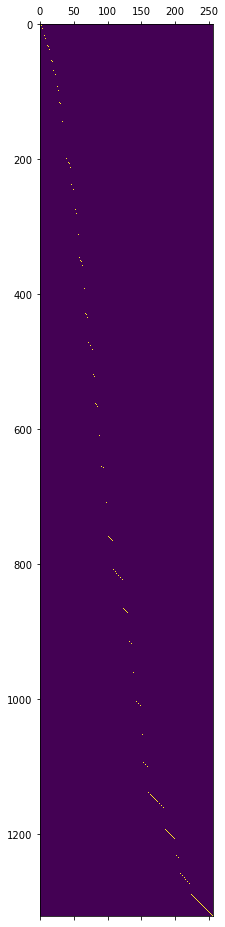

In [239]:
def populate_matrix_based_on_labels(input_vector, node_labels):
    # Determine the matrix size
    rows = len(node_labels)
    cols = len(input_vector)
    
    # Initialize the matrix with zeros
    matrix = np.zeros((rows, cols))
    
    # Track the current column to fill in the matrix
    current_col = 0
    
    # Iterate over node_labels to fill the matrix
    for i, label in enumerate(node_labels):
        if label == 'b' and current_col < cols:
            # If the label is 'b', populate the matrix at the current column and row i
            matrix[i, current_col] = input_vector[current_col]
            # Move to the next column for the next 'b'
            current_col += 1
    
    return matrix

# Populate the B matrix based on the node_labels
B_DG0_test = populate_matrix_based_on_labels(reorder_B, node_labels)
plt.matshow(B_DG0_test)

In [240]:
import numpy as np

def map_dof_to_bnd_pts(bnd_pts, dof, node_labels):
    # Identify indices in dof where node_labels is 'b'¨
    node_labels = np.array(node_labels)
    b_indices = np.where(node_labels == 'b')[0]    
    #print(b_indices)
    
    # identify the indices of i

    # Filter dof points that are labeled as 'b'
    dof_b = dof[b_indices]
    
    # Initialize an empty mapping dictionary: dof index to bnd_pts index
    mapping = {}
    
    # Iterate over each dof point labeled as 'b'
    for i, dof_point in enumerate(dof_b):
        # Find the matching point in bnd_pts
        for j, bnd_point in enumerate(bnd_pts):
            if np.array_equal(dof_point, bnd_point):
                # Map dof index to bnd_pts index
                mapping[b_indices[i]] = j
                break
    
    return mapping


# Call the function
mapping = map_dof_to_bnd_pts(bnd_pts, dof_coordinates, node_labels)
#print(mapping)

In [241]:
def reorder_matrix_based_on_dof(original_matrix, mapping):
    # Determine the size of the matrix
    N = original_matrix.shape[0]
    
    # Initialize a new matrix of the same size
    reordered_matrix = np.zeros_like(original_matrix)
    
    # Create a list of new column indices based on the sorted dof indices (values of the mapping)
    new_order = [mapping[k] for k in sorted(mapping.keys())]
    
    # Rearrange the columns of the original matrix to the new order
    for new_idx, old_idx in enumerate(new_order):
        reordered_matrix[:, new_idx] = original_matrix[:, old_idx]
    
    return reordered_matrix


P_reordered = reorder_matrix_based_on_dof(P, mapping)

# Check if the reordering is correct
np.savetxt('P_reordered.txt', P_reordered, fmt='%1.4e')
np.savetxt('P.txt', P, fmt='%1.4e')

Q_reordered = reorder_matrix_based_on_dof(Q, mapping)

In [242]:
def insert_zero_columns(input_matrix, node_labels):
    # Determine the total number of columns for the new matrix
    node_labels = np.array(node_labels)

    total_columns = len(node_labels)
    # Initialize the new matrix with zeros
    # Number of rows from the input matrix, number of columns from node_labels
    new_matrix = np.zeros((input_matrix.shape[0], total_columns),dtype=complex)
    
    # Track the current column in the input matrix to be added to the new matrix
    input_matrix_col = 0
    
    # Iterate through node_labels to determine placement of input matrix columns or zeros
    for i, label in enumerate(node_labels):
        if label == 'b':
            new_matrix[:, i] = input_matrix[:, input_matrix_col]
            input_matrix_col += 1  # Move to the next column in the input matrix for the next 'b'
        # Note: 'i' labeled columns are already initialized to zero, so no action needed for 'i'
    
    return new_matrix

# Call the function
P_reordered_zeroed = insert_zero_columns(P_reordered, node_labels)
np.shape(P_reordered_zeroed)

# Check if the zero insertion is correct
np.savetxt('P_reordered_zeroed.txt', P_reordered_zeroed, fmt='%1.4e')


In [243]:
print(B)

In [244]:
# def remove_i_columns(input_matrix, node_labels):
#     # Find indices where node_labels is 'b', indicating columns to keep
#     node_labels = np.array(node_labels)
#     b_indices = np.where(node_labels == 'b')[0]
    
#     # Select only the columns from the input matrix that correspond to 'b' indices
#     new_matrix = input_matrix[:, b_indices]
    
#     return new_matrix

# # Call the function
# B_zeroed = remove_i_columns(B, node_labels)

# # Check if the zero removal is correct
# np.savetxt('B_zeroed.txt', B_zeroed, fmt='%1.4e')

In [245]:
import numpy as np

def reorder_vector_based_on_dof(original_vector, mapping):
    # Determine the size of the vector
    N = original_vector.shape[0]
    
    # Initialize a new vector of the same size
    reordered_vector = np.zeros_like(original_vector)
    
    # Create a list of new indices based on the sorted dof indices (values of the mapping)
    new_order = [mapping[k] for k in sorted(mapping.keys())]
    
    # Rearrange the elements of the original vector to the new order
    for new_idx, old_idx in enumerate(new_order):
        reordered_vector[new_idx] = original_vector[old_idx]
    
    return reordered_vector


#test_vector = np.array([2, 4, 6, 8, 10, 12, 14,16])
print(mapping)
# Call the function
#reordered_test_vector = reorder_vector_based_on_dof(test_vector, mapping)

#print(reordered_test_vector)

{0: 161, 1: 160, 3: 162, 8: 163, 9: 159, 16: 164, 18: 157, 19: 158, 22: 155, 23: 156, 32: 167, 33: 166, 34: 165, 38: 153, 39: 154, 50: 169, 51: 168, 55: 151, 56: 152, 70: 171, 71: 170, 75: 148, 76: 149, 77: 150, 93: 173, 94: 172, 98: 146, 99: 147, 117: 176, 118: 175, 119: 174, 140: 178, 141: 177, 145: 144, 146: 145, 151: 142, 152: 143, 174: 180, 175: 179, 200: 182, 201: 181, 205: 139, 206: 140, 207: 141, 212: 137, 213: 138, 239: 185, 240: 184, 241: 183, 246: 135, 247: 136, 275: 187, 276: 186, 281: 133, 282: 134, 312: 189, 313: 188, 346: 191, 347: 190, 351: 130, 352: 131, 353: 132, 358: 128, 359: 129, 392: 194, 393: 193, 394: 192, 430: 196, 431: 195, 434: 126, 435: 127, 472: 198, 473: 197, 476: 123, 477: 124, 478: 125, 482: 121, 483: 122, 519: 200, 520: 199, 523: 119, 524: 120, 563: 203, 564: 202, 565: 201, 567: 117, 568: 118, 609: 205, 610: 204, 611: 114, 655: 207, 656: 206, 657: 115, 658: 116, 659: 113, 660: 112, 707: 210, 708: 209, 709: 208, 710: 111, 711: 110, 760: 212, 761: 211, 76

Number of non-zero elements in P_altered: 65536
The shape of K is: (1322, 1322)
The shape of B is: (1322, 256)
The shape of P is: (256, 1322)
The shape of Q is: (256, 256)


The shape of phi is: (1322,)
The shape of psi is: (256,)
Time to solve coupled system: 0.57 seconds


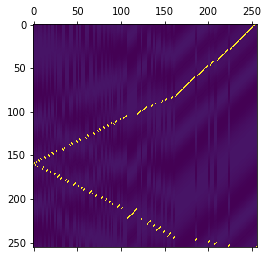

In [246]:
# Get the excitation vector
b_vec = mom.plane_wave_excitation(kb, col_pts)
b_vec_reordered = reorder_vector_based_on_dof(b_vec, mapping)
# Solve the system
phi, psi = sol.solve_block_brute_force(K,B_DG0_test,P_reordered_zeroed,Q_reordered,b_vec)
plt.matshow(P_reordered.real)

In [247]:
M = np.linalg.solve(P_reordered, b_vec_reordered)
J = np.linalg.solve(Q_reordered, b_vec_reordered)

In [248]:
# We need to map the phi values to the boundary nodes. Psi are only on the boundary nodes
boundary_phi = []
interior_phi = []
for idx, label in enumerate(node_labels):
    if label == 'b':
        # Append only the phi value for boundary nodes
        boundary_phi.append(phi[idx])
    else:
        # Assuming you want to do a similar action for interior nodes
        interior_phi.append(phi[idx])
boundary_phi = np.array(boundary_phi)

In [257]:
scattered_field = mom.calculate_scattered_field(coordinates, boundary_phi, psi, bnd_pts, bnd_seg, col_pts, kb)

Progress: [##################################################] 100.0%
Scattered field calculated


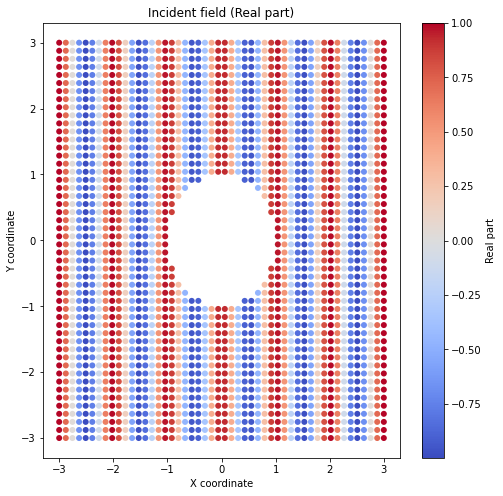

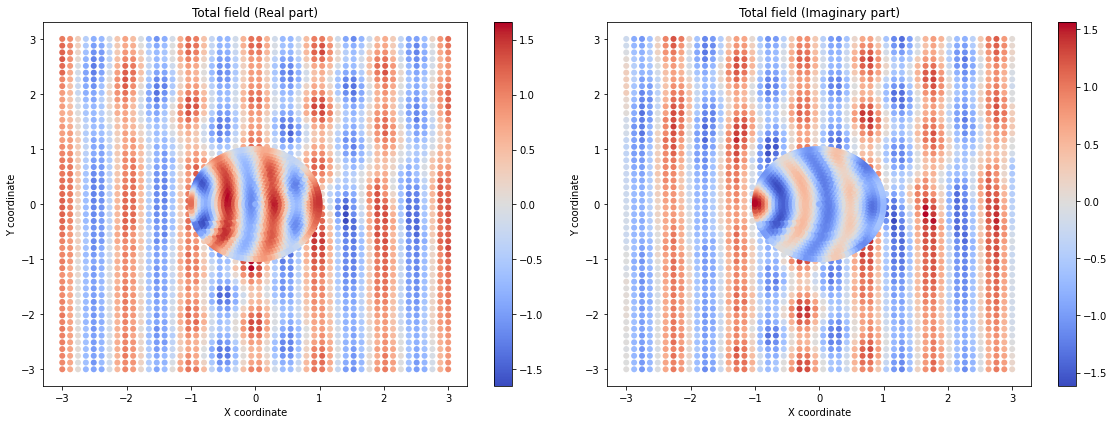

In [258]:
vis.plot_scattered_field(coordinates, scattered_field, dof_coordinates, phi, kb)


[0.         0.02463994 0.04927988 0.07391983 0.09855977 0.12319971
 0.14783965 0.1724796  0.19711954 0.22175948 0.24639942 0.27103937
 0.29567931 0.32031925 0.34495919 0.36959914 0.39423908 0.41887902
 0.44351896 0.46815891 0.49279885 0.51743879 0.54207873 0.56671867
 0.59135862 0.61599856 0.6406385  0.66527844 0.68991839 0.71455833
 0.73919827 0.76383821 0.78847816 0.8131181  0.83775804 0.86239798
 0.88703793 0.91167787 0.93631781 0.96095775 0.9855977  1.01023764
 1.03487758 1.05951752 1.08415746 1.10879741 1.13343735 1.15807729
 1.18271723 1.20735718 1.23199712 1.25663706 1.281277   1.30591695
 1.33055689 1.35519683 1.37983677 1.40447672 1.42911666 1.4537566
 1.47839654 1.50303649 1.52767643 1.55231637 1.57695631 1.60159625
 1.6262362  1.65087614 1.67551608 1.70015602 1.72479597 1.74943591
 1.77407585 1.79871579 1.82335574 1.84799568 1.87263562 1.89727556
 1.92191551 1.94655545 1.97119539 1.99583533 2.02047528 2.04511522
 2.06975516 2.0943951  2.11903504 2.14367499 2.16831493 2.19295

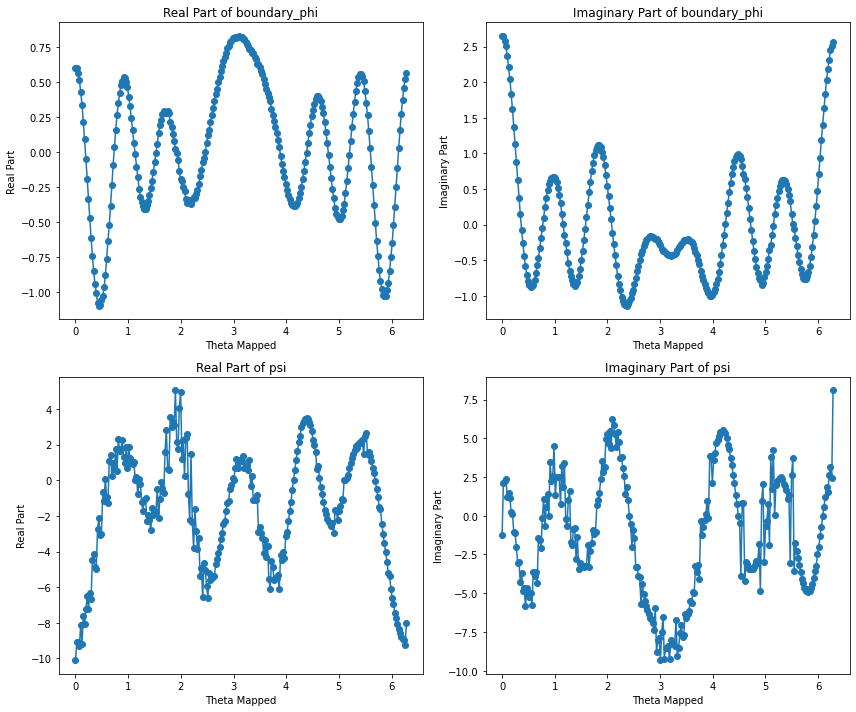

In [251]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'reorder_vector_based_on_dof' is a predefined function and
# 'mapping', 'boundary_phi', 'psi', 'boundary_phi_imag', 'psi_imag' variables are already defined.

N = len(psi)
theta = np.linspace(0, 2*np.pi, N)
theta_mapped = reorder_vector_based_on_dof(theta, mapping)

# Join theta_mapped, boundary_phi, psi and their imaginary parts into a DataFrame
df = pd.DataFrame({
    'theta_mapped': theta_mapped,
    'boundary_phi_real': np.real(boundary_phi),
    'psi_real': np.real(psi),
    'boundary_phi_imag': np.imag(boundary_phi),
    'psi_imag': np.imag(psi)
})

# Sort the DataFrame by theta_mapped to get back to the interval from 0 to 2π
df_sorted = df.sort_values(by='theta_mapped')

# Convert sorted data to NumPy arrays for plotting
theta_mapped_np = df_sorted['theta_mapped'].to_numpy()
boundary_phi_real_np = df_sorted['boundary_phi_real'].to_numpy()
psi_real_np = df_sorted['psi_real'].to_numpy()
boundary_phi_imag_np = df_sorted['boundary_phi_imag'].to_numpy()
psi_imag_np = df_sorted['psi_imag'].to_numpy()
print(theta_mapped_np)
# Plot real and imaginary parts of boundary_phi and psi in individual subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))  # Creates a 2x2 grid of subplots

# Real part of boundary_phi
axs[0, 0].plot(theta_mapped_np, boundary_phi_real_np, marker='o', linestyle='-')
axs[0, 0].set_title('Real Part of boundary_phi')
axs[0, 0].set_xlabel('Theta Mapped')
axs[0, 0].set_ylabel('Real Part')

# Imaginary part of boundary_phi
axs[0, 1].plot(theta_mapped_np, boundary_phi_imag_np, marker='o', linestyle='-')
axs[0, 1].set_title('Imaginary Part of boundary_phi')
axs[0, 1].set_xlabel('Theta Mapped')
axs[0, 1].set_ylabel('Imaginary Part')

# Real part of psi
axs[1, 0].plot(theta_mapped_np, psi_real_np, marker='o', linestyle='-')
axs[1, 0].set_title('Real Part of psi')
axs[1, 0].set_xlabel('Theta Mapped')
axs[1, 0].set_ylabel('Real Part')

# Imaginary part of psi
axs[1, 1].plot(theta_mapped_np, psi_imag_np, marker='o', linestyle='-')
axs[1, 1].set_title('Imaginary Part of psi')
axs[1, 1].set_xlabel('Theta Mapped')
axs[1, 1].set_ylabel('Imaginary Part')

plt.tight_layout()  # Adjusts subplot params so that subplots are nicely fit in the figure area
plt.show()


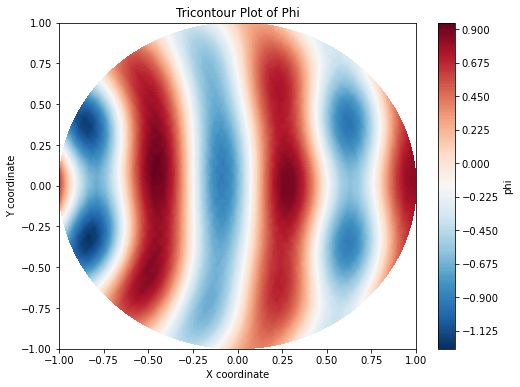

In [252]:
# Extract x and y coordinates
x = dof_coordinates[:, 0]
y = dof_coordinates[:, 1]

# Create a tricontour plot
plt.figure(figsize=(8, 6))
#plt.tricontour(x, y, phi.real, levels=14, linewidths=0.5, colors='k')
plt.tricontourf(-x, y, phi.real, levels=146, cmap="RdBu_r")
plt.colorbar(label='phi')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.title('Tricontour Plot of Phi')
plt.show()

[  0.        1.40625   2.8125    4.21875   5.625     7.03125   8.4375
   9.84375  11.25     12.65625  14.0625   15.46875  16.875    18.28125
  19.6875   21.09375  22.5      23.90625  25.3125   26.71875  28.125
  29.53125  30.9375   32.34375  33.75     35.15625  36.5625   37.96875
  39.375    40.78125  42.1875   43.59375  45.       46.40625  47.8125
  49.21875  50.625    52.03125  53.4375   54.84375  56.25     57.65625
  59.0625   60.46875  61.875    63.28125  64.6875   66.09375  67.5
  68.90625  70.3125   71.71875  73.125    74.53125  75.9375   77.34375
  78.75     80.15625  81.5625   82.96875  84.375    85.78125  87.1875
  88.59375  90.       91.40625  92.8125   94.21875  95.625    97.03125
  98.4375   99.84375 101.25    102.65625 104.0625  105.46875 106.875
 108.28125 109.6875  111.09375 112.5     113.90625 115.3125  116.71875
 118.125   119.53125 120.9375  122.34375 123.75    125.15625 126.5625
 127.96875 129.375   130.78125 132.1875  133.59375 135.      136.40625
 137.8125  139.218

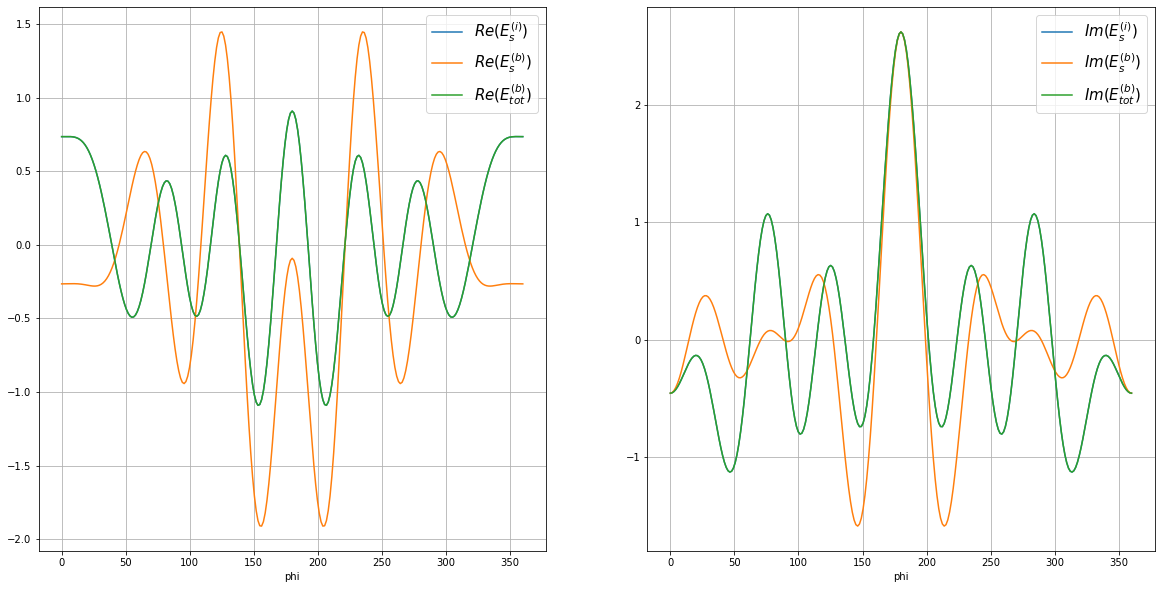

In [253]:
import numpy as np
import matplotlib.pyplot as plt

# Load the data
data = np.load('plot_data.npz')

# Access the variables
phi_deg = data['phi_deg']
real_Eis = data['real_Eis']
real_Ebs = data['real_Ebs']
real_Eb = data['real_Eb']
imag_Eis = data['imag_Eis']
imag_Ebs = data['imag_Ebs']
imag_Eb = data['imag_Eb']

# Now, plotting as before
fig = plt.figure(figsize=(20,10))
print(phi_deg)
ax = fig.add_subplot(1,2,1)
ax.plot(phi_deg, real_Eis, label=r'$Re(E_s^{(i)})$')
ax.plot(phi_deg, real_Ebs, label=r'$Re(E_s^{(b)})$')
ax.plot(phi_deg, real_Eb,  label=r'$Re(E_{tot}^{(b)})$')
ax.legend(prop={'size': 15})
ax.set_xlabel('phi')
ax.grid()

ax = fig.add_subplot(1,2,2)
ax.plot(phi_deg, imag_Eis, label=r'$Im(E_s^{(i)})$')
ax.plot(phi_deg, imag_Ebs, label=r'$Im(E_s^{(b)})$')
ax.plot(phi_deg, imag_Eb,  label=r'$Im(E_{tot}^{(b)})$')
ax.legend(prop={'size': 15})
ax.set_xlabel('phi')
ax.grid()

plt.show()


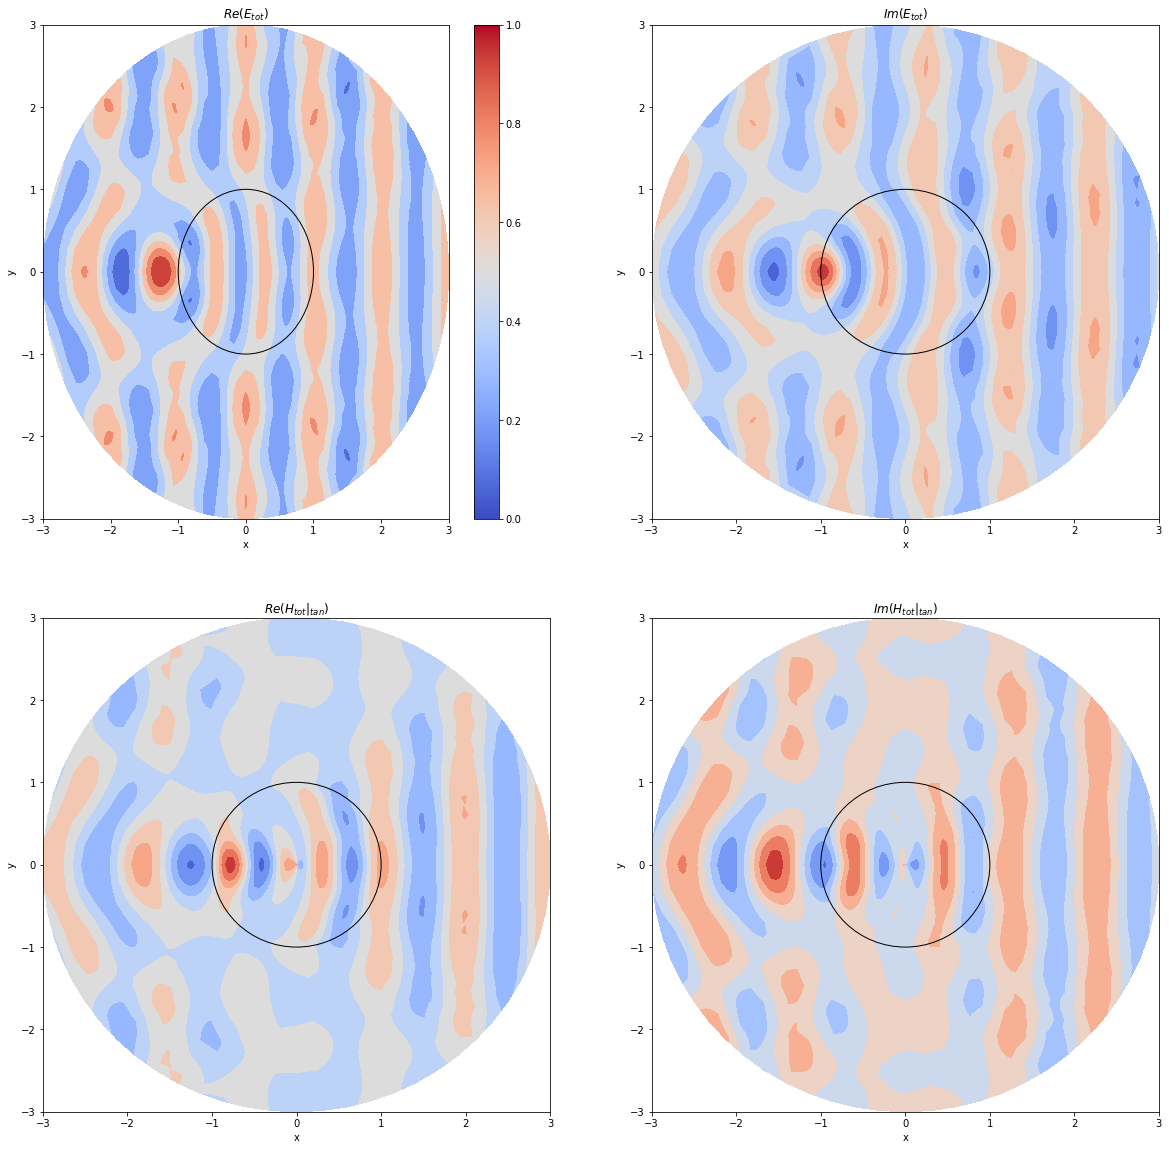

In [254]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# Load the data
data = np.load('contour_plot_data.npz')

# Access the variables
X = data['X']
Y = data['Y']
real_E = data['real_E']
imag_E = data['imag_E']
real_Htan = data['real_Htan']
imag_Htan = data['imag_Htan']
a = data['a']

# Now, plotting as before
fig = plt.figure(figsize=(20,20))
cmap = cm.coolwarm

ax = fig.add_subplot(2,2,1)
contourf_plot = ax.contourf(X, Y, real_E, cmap=cmap)
cyl = plt.Circle((0, 0), a, color='k', fill=False)
ax.set_title(r'$Re(E_{tot})$')
ax.add_patch(cyl)
ax.set_xlabel('x')
ax.set_ylabel('y')
fig.colorbar(cm.ScalarMappable(cmap=cmap), ax=ax, orientation='vertical')

ax = fig.add_subplot(2,2,2)
ax.contourf(X, Y, imag_E, cmap=cmap)
cyl = plt.Circle((0, 0), a, color='k', fill=False)
ax.set_title(r'$Im(E_{tot})$')
ax.add_patch(cyl)
ax.set_xlabel('x')
ax.set_ylabel('y')

ax = fig.add_subplot(2,2,3)
ax.contourf(X, Y, real_Htan, cmap=cmap)
cyl = plt.Circle((0, 0), a, color='k', fill=False)
ax.add_patch(cyl)
ax.set_title(r'$Re(H_{tot}|_{tan})$')
ax.set_xlabel('x')
ax.set_ylabel('y')

ax = fig.add_subplot(2,2,4)
ax.contourf(X, Y, imag_Htan, cmap=cmap)
cyl = plt.Circle((0, 0), a, color='k', fill=False)
ax.set_title(r'$Im(H_{tot}|_{tan})$')
ax.add_patch(cyl)
ax.set_xlabel('x')
ax.set_ylabel('y')

plt.show()


1


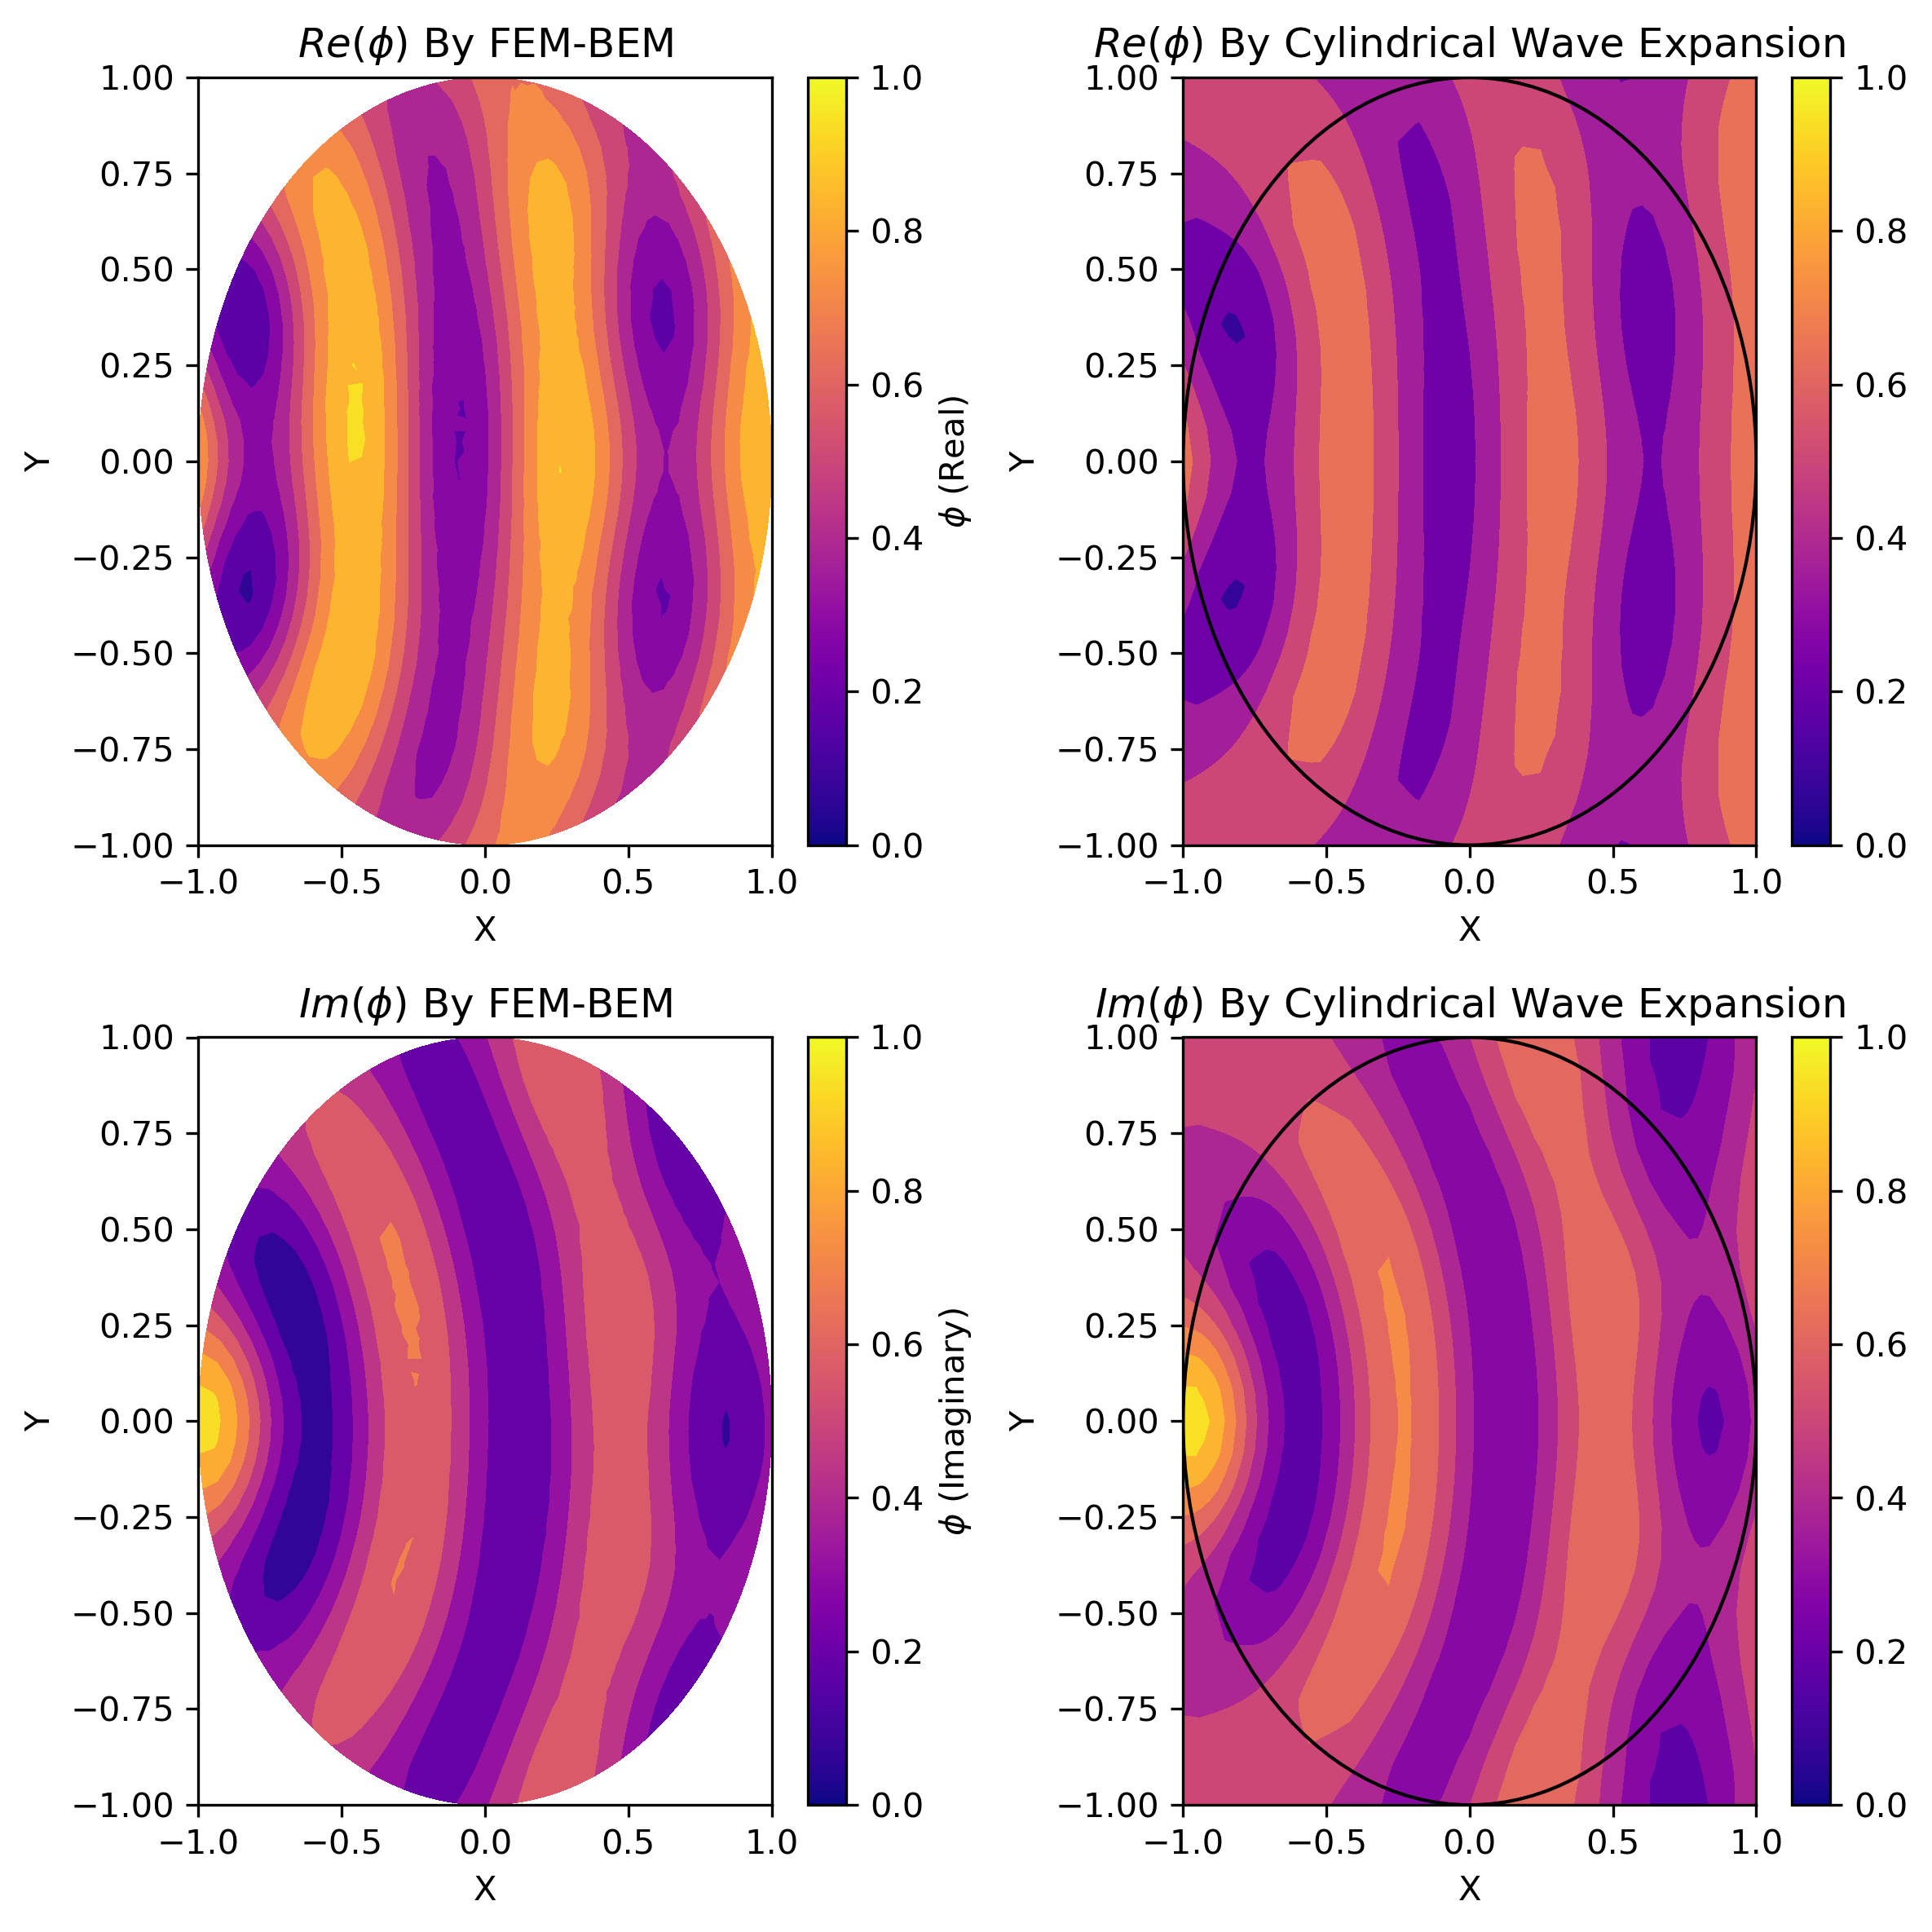

In [255]:
import matplotlib.pyplot as plt
from matplotlib import cm

# Assuming 'dof_coordinates', 'phi', and 'data' are already defined

# Access the variables from 'data'
X = data['X']
Y = data['Y']
real_E = data['real_E']
imag_E = data['imag_E']  # Assuming this is how you access the imaginary part of E
real_Htan = data['real_Htan']  # Assuming this is for reference, not used in the given plots
imag_Htan = data['imag_Htan']  # Assuming this is for reference, not used in the given plots
a = data['a']
print(a)
# Extract x and y coordinates from 'dof_coordinates'
x = dof_coordinates[:, 0]
y = dof_coordinates[:, 1]
# Normalize phi.real
phi_real_min = np.min(phi.real)
phi_real_max = np.max(phi.real)
phi_real_normalized = (phi.real - phi_real_min) / (phi_real_max - phi_real_min)

# Normalize phi.imag
phi_imag_min = np.min(phi.imag)
phi_imag_max = np.max(phi.imag)
phi_imag_normalized = (phi.imag - phi_imag_min) / (phi_imag_max - phi_imag_min)

# Setup the figure and axes for a 2x2 subplot structure
fig, axs = plt.subplots(2, 2, figsize=(8, 8),dpi = 300)

# First column, first row: Tricontour plot of the real part of phi
cmap_rdbu = cm.plasma
axs[0, 0].tricontourf(-x, y, phi.real, cmap=cmap_rdbu)
axs[0, 0].set_title(r'$Re(\phi)$ By FEM-BEM')
axs[0, 0].set_xlabel('X')
axs[0, 0].set_ylabel('Y')
fig.colorbar(cm.ScalarMappable(cmap=cmap_rdbu), ax=axs[0, 0], orientation='vertical', label=r'$\phi$ (Real)')

# First column, second row: Tricontour plot of the imaginary part of phi
# Adjust as necessary for plotting the imaginary part, assuming phi.imag is accessible
axs[1, 0].tricontourf(-x, y, phi.imag, cmap=cmap_rdbu)
axs[1, 0].set_title(r'$Im(\phi)$ By FEM-BEM')
axs[1, 0].set_xlabel('X')
axs[1, 0].set_ylabel('Y')
fig.colorbar(cm.ScalarMappable(cmap=cmap_rdbu), ax=axs[1, 0], orientation='vertical', label=r'$\phi$ (Imaginary)')

# Second column, first row: Contour plot of real_E with restricted x and y limits
cmap_coolwarm = cm.plasma
contourf_plot = axs[0, 1].contourf(X, Y, real_E, cmap=cmap_coolwarm)
cyl = plt.Circle((0, 0), 1, color='k', fill=False)
axs[0, 1].set_title(r'$Re(\phi)$ By Cylindrical Wave Expansion')
axs[0, 1].add_patch(cyl)
axs[0, 1].set_xlabel('X')
axs[0, 1].set_ylabel('Y')
axs[0, 1].set_xlim([-1, 1])  # Set x-axis limit
axs[0, 1].set_ylim([-1, 1])  # Set y-axis limit
fig.colorbar(cm.ScalarMappable(cmap=cmap_coolwarm), ax=axs[0, 1], orientation='vertical')

# Second column, second row: Contour plot of imag_E with restricted x and y limits
contourf_plot_imag = axs[1, 1].contourf(X, Y, imag_E, cmap=cmap_coolwarm)
axs[1, 1].set_title(r'$Im(\phi)$ By Cylindrical Wave Expansion')
axs[1, 1].add_patch(plt.Circle((0, 0), 1, color='k', fill=False))
axs[1, 1].set_xlabel('X')
axs[1, 1].set_ylabel('Y')
axs[1, 1].set_xlim([-1, 1])  # Set x-axis limit
axs[1, 1].set_ylim([-1, 1])  # Set y-axis limit
fig.colorbar(cm.ScalarMappable(cmap=cmap_coolwarm), ax=axs[1, 1], orientation='vertical')


plt.tight_layout()
plt.savefig('contour_plots_high_k.eps',format='eps', dpi=300)
plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


256
257


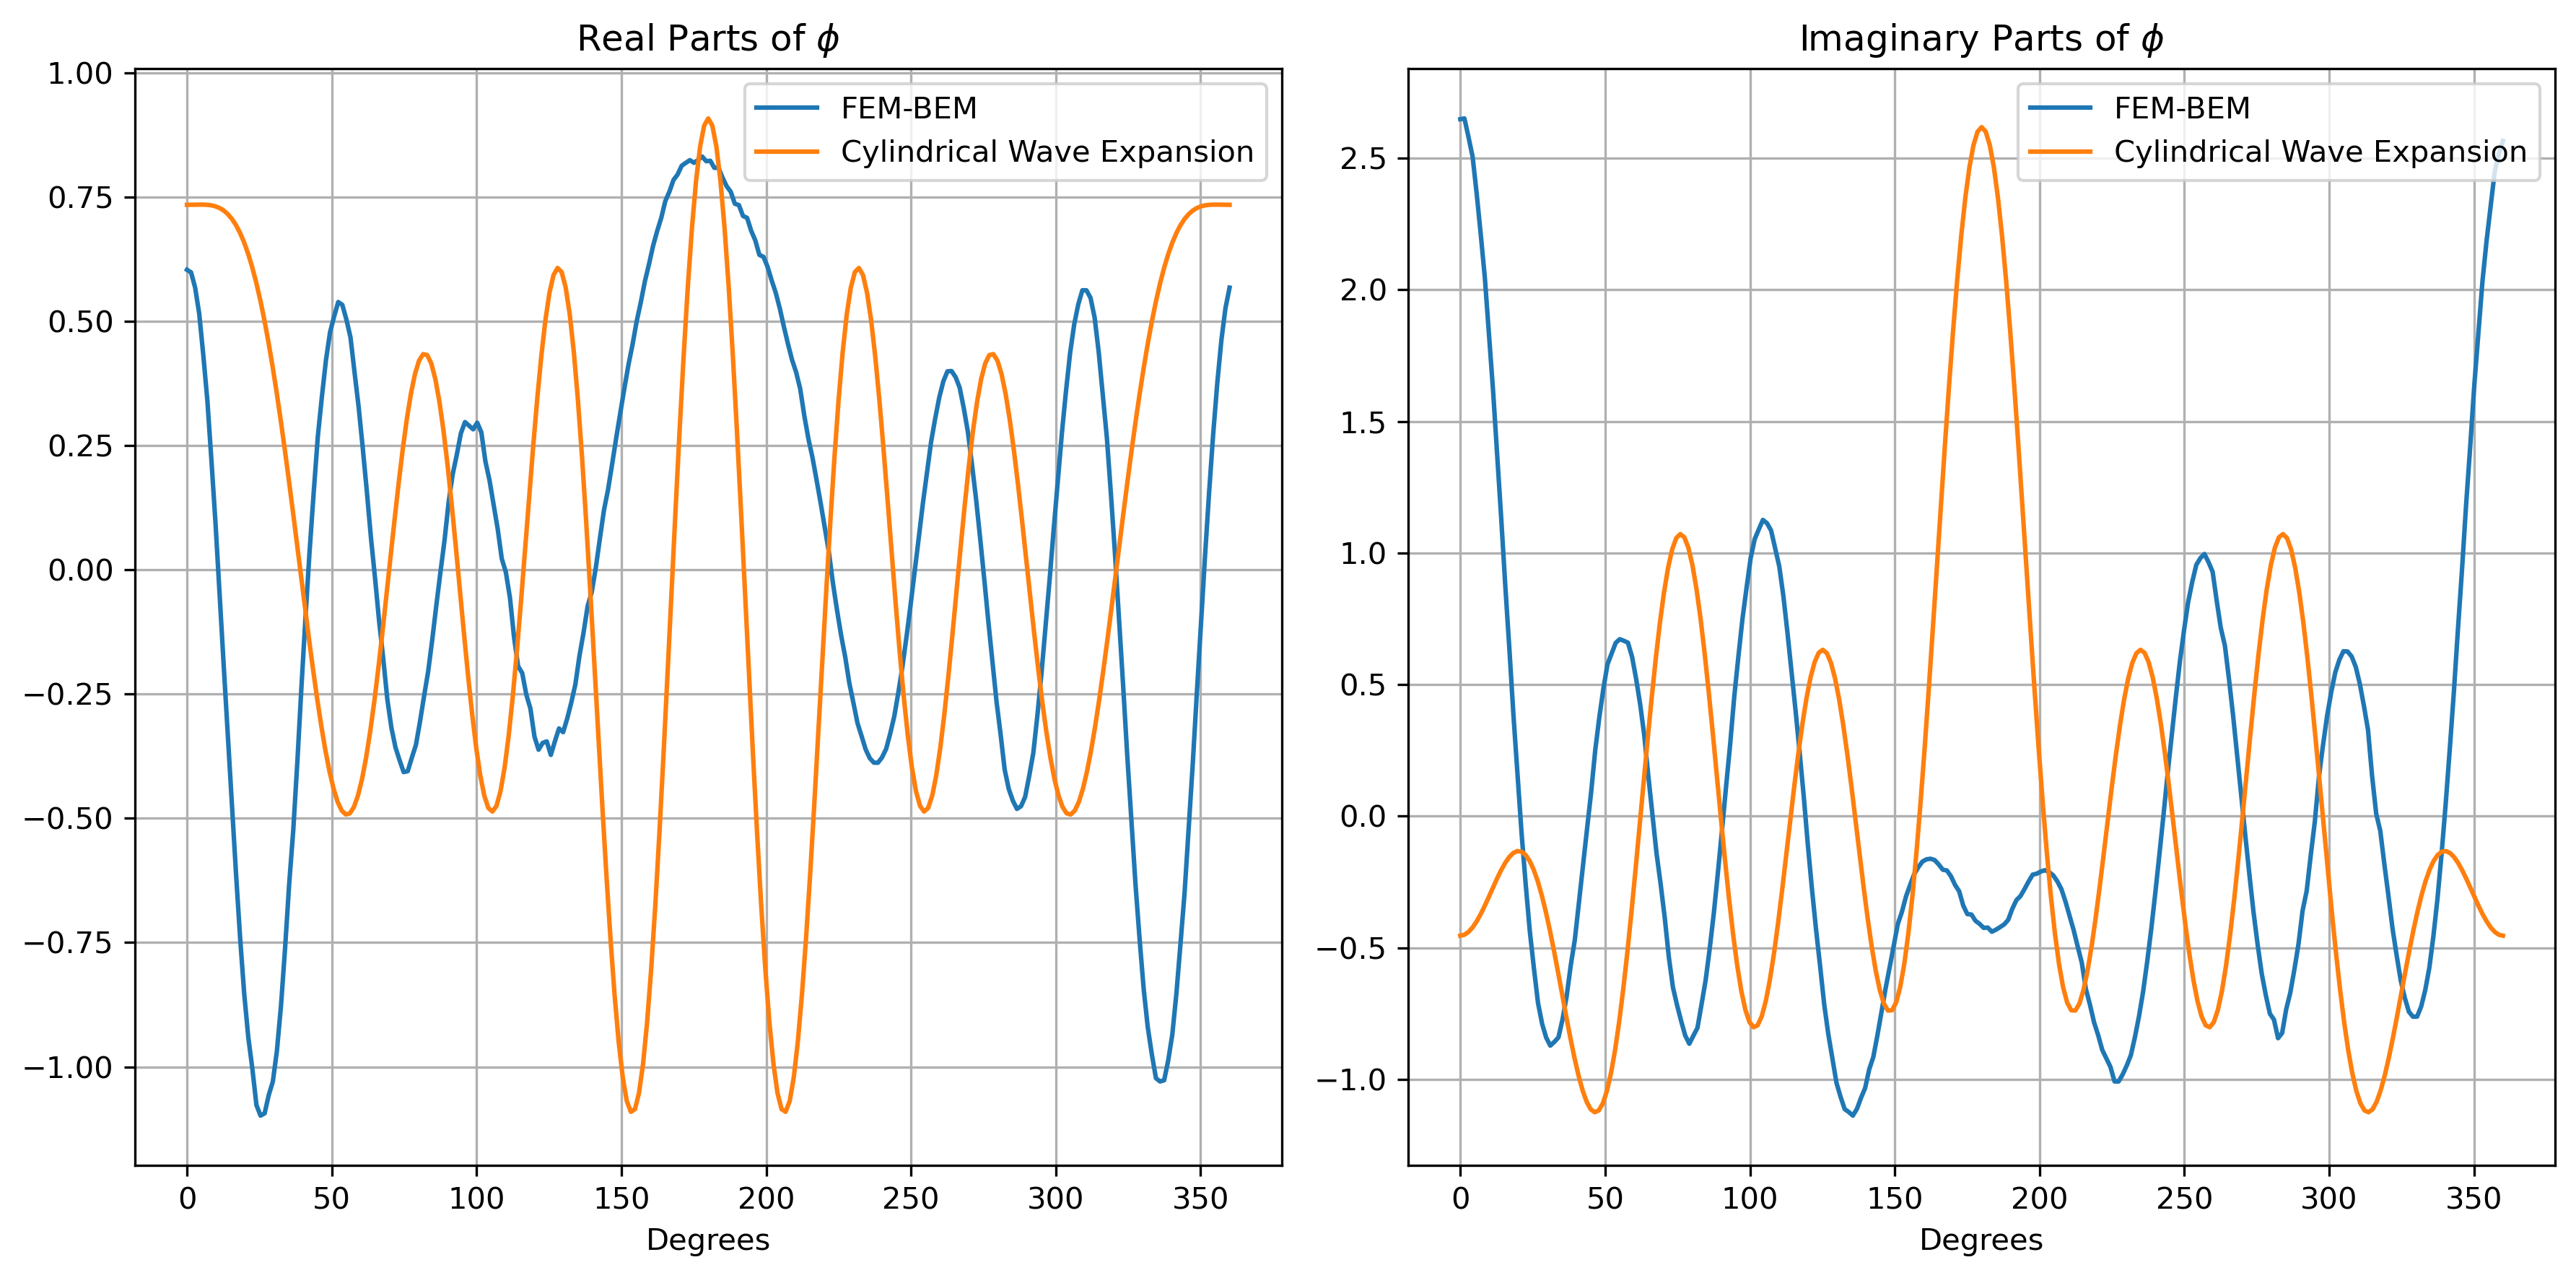

In [256]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming the necessary variables are defined: 
# theta_mapped_np, boundary_phi_real_np, boundary_phi_imag_np, 
# phi_deg, real_Eis, real_Ebs, real_Eb, imag_Eis, imag_Ebs, imag_Eb

# Convert theta_mapped from radians to degrees
theta_mapped_deg = np.degrees(theta_mapped_np)
print(len(theta_mapped_deg))
print(len(phi_deg))
# Create a 1x2 grid of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6),dpi = 300)

# Plot the real parts on the first subplot
axs[0].plot(theta_mapped_deg, boundary_phi_real_np, '-', label='FEM-BEM')
axs[0].plot(phi_deg, real_Eb, '-', label='Cylindrical Wave Expansion')
axs[0].set_title(r'Real Parts of $\phi$')
axs[0].set_xlabel('Degrees')
axs[0].legend()
axs[0].grid()

# Plot the imaginary parts on the second subplot
axs[1].plot(theta_mapped_deg, boundary_phi_imag_np, '-', label='FEM-BEM')
axs[1].plot(phi_deg, imag_Eb, '-', label='Cylindrical Wave Expansion')
axs[1].set_title(r'Imaginary Parts of $\phi$')
axs[1].set_xlabel('Degrees')
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.savefig('real_imag_parts_line_highk.eps',format='eps', dpi=300)
plt.show()

